# Stage 5: Imbalanced Dataset

Class Imbalance is a common problem in machine learning, especially in classification.
Most ML algorithms work best when the number of samples in each class are about equal.
Our dataset is imbalanced with a target value of 15%; We will get high accuracy just by predicting the majority class, but we will fail to capture the minority class, which is the point of creating the model in the first place.
In this stage we will find the technique to find the dataset balance that will provide us with the best performance. 

In [1]:
#PART 1
!pip install matplotlib
!pip install imbalanced-learn
import imblearn
print(imblearn.__version__)
#import random undersampling and other necessary libraries 
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

0.9.1


Imbalanced dataset process is performed with the train dataframe only

In [2]:
#uploading the train data
df_train = pd.read_csv('Amsterdam_train.csv')
df_train.head()

,Unnamed: 0,host_neighbourhood,host_total_listings_count,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,host_is_superhost,split
0,5554,16.0,1,1,19.0,5.0,52.380491,4.887432,1.0,0.0,...,158,16,100,10,10,10,10,10,0,0.0
1,4382,31.0,1,0,37.0,7.0,52.367068,4.866769,1.0,1.0,...,34,12,87,9,9,9,9,9,0,0.0
2,13026,41.0,1,0,50.0,16.0,52.391986,4.925497,13.0,0.0,...,0,10,92,9,9,9,10,9,0,0.0
3,7085,8.0,1,1,11.0,8.0,52.350850,4.895104,1.0,0.0,...,0,13,97,10,9,10,10,10,0,0.0
4,16572,31.0,1,0,37.0,7.0,52.369953,4.858866,15.0,0.0,...,0,14,80,9,7,8,9,9,0,0.0


In [3]:
#stubborn upload bug
del df_train['Unnamed: 0']

In [4]:
df_train.shape

(16024, 33)

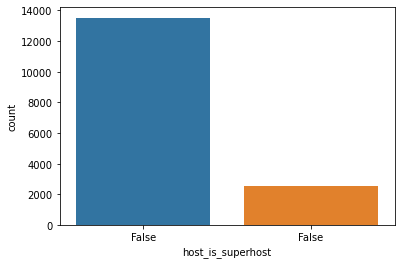

In [5]:
# visualize the target variable
g = sns.countplot(df_train['host_is_superhost'])
g.set_xticklabels(['host_is_superhost'==0,'host_is_superhost'==1])

plt.show()


# The Metric Trap

Running example with xgboost 

In [6]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X= df_train.loc[:,df_train.columns != 'host_is_superhost']
y = df_train['host_is_superhost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[22:02:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 87.77%


We got 88% accuracy with xgboost classsifier; provided prediction of the host_is_soperhost = 0

In [7]:
# class count
class_count_0, class_count_1 = df_train['host_is_superhost'].value_counts()

# Separate class
class_0 = df_train[df_train['host_is_superhost'] == 0]
class_1 = df_train[df_train['host_is_superhost'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)
print('difference:', (df_train['host_is_superhost'] == 0).sum()-(df_train['host_is_superhost'] == 1).sum())
print('mid range', df_train['host_is_superhost'].sum()/2 )

class 0: (13507, 33)
class 1: (2517, 33)
difference: 10990
mid range 1258.5


# Confusion matrix

Therefore, the higher the diagonal values of the confusion matrix - the better, indicating many correct predictions.

Confusion matrix:
 [[1279   79]
 [ 117  128]]


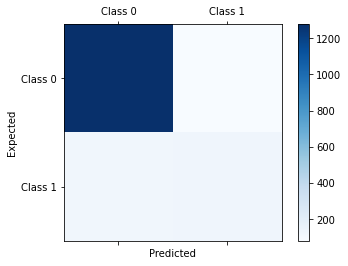

In [8]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [9]:
# Class count
count_class_0, count_class_1 = df_train['host_is_superhost'].value_counts()

# Divide df by class
df_class_0 = df_train[df_train['host_is_superhost'] == 0]
df_class_1 = df_train[df_train['host_is_superhost'] == 1]

### 1. Random Under-Sampling

Visualizing balanced datasets: first cutting the majority value to the level of the minority. Than – creating additional data from the minority (Target Value)

Random under-sampling:
0    2517
1    2517
Name: host_is_superhost, dtype: int64


[Text(0.5, 1.0, 'Under Sampling')]

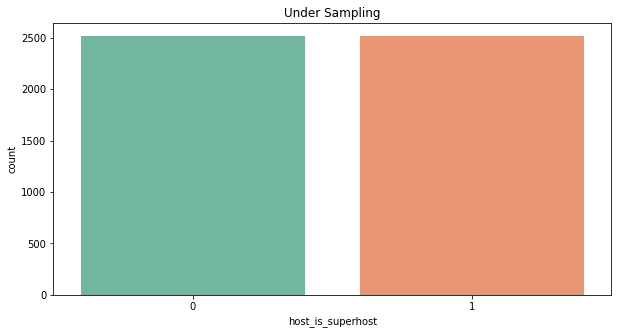

In [10]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under['host_is_superhost'].value_counts())

fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x=df_test_under['host_is_superhost'].dropna(),data=df_test_under, palette="Set2").set(title='Under Sampling')

### 2. Random Over-Sampling


Random over-sampling:
1    13507
0    13507
Name: host_is_superhost, dtype: int64


[Text(0.5, 1.0, 'Over Sampling')]

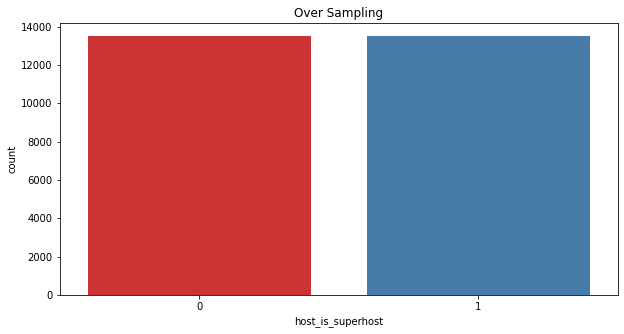

In [11]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_1_over, df_class_0], axis=0)

print('Random over-sampling:')
print(df_test_over['host_is_superhost'].value_counts())

fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x=df_test_over['host_is_superhost'].dropna(),data=df_test_over, palette="Set1").set(title='Over Sampling')

# Imbalanced Techniques 

In [12]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler 
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

In [13]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
       n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

Visualizing Classes

In [14]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

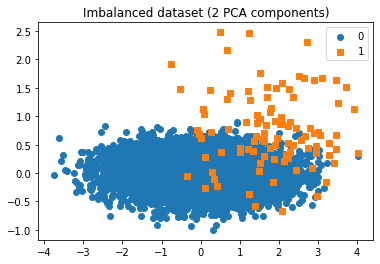

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

# Random Under-Sampling

The following models will provide blancing resluts and accuracy using Random Forest Classifier
We choose sampling_strategy='all'

original dataset shape: Counter({0: 9900, 1: 100})
Resample dataset shape Counter({0: 100, 1: 100})
0 new random picked points


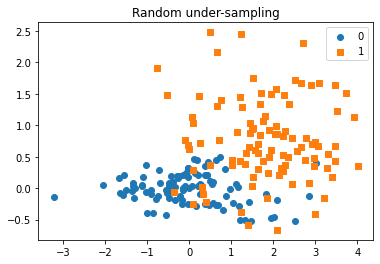

In [16]:
# import library
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()# fit predictor and target variable
X_rus, y_rus = rus.fit_resample(X, y)

print('original dataset shape:', Counter(y))
print('Resample dataset shape', Counter(y_rus))
print(X_rus.shape[1] - X.shape[1], 'new random picked points')

plot_2d_space(X_rus, y_rus, 'Random under-sampling')

In [17]:
#Define model
model=RandomForestClassifier()
#Define sampler
rus_resample = RandomUnderSampler(sampling_strategy='all')
#Define pipeline
pipeline=Pipeline(steps=[('r', rus_resample), ('m', model)])
#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores['test_recall_macro']))

Mean Accuracy: 0.9109
Mean Precision: 0.5465
Mean Recall: 0.8956


# Random Over-Sampling

Generate new samples in the minority classes

original dataset shape: Counter({0: 9900, 1: 100})
Resample dataset shape Counter({0: 9900, 1: 9900})
9800 new random picked points


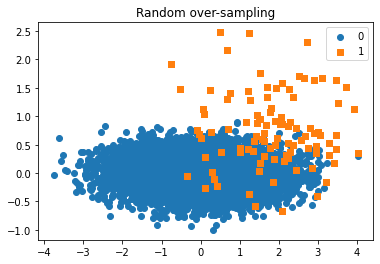

In [18]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

print('original dataset shape:', Counter(y))
print('Resample dataset shape', Counter(y_ros))
print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')

In [19]:
#Define model
model=RandomForestClassifier()
#Define sampler
ros_resample = RandomOverSampler(sampling_strategy='all')
#Define pipeline
pipeline=Pipeline(steps=[('r', ros_resample), ('m', model)])
#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores['test_recall_macro']))

Mean Accuracy: 0.9929
Mean Precision: 0.8456
Mean Recall: 0.7572


Checking distribution differences

<AxesSubplot:ylabel='Density'>

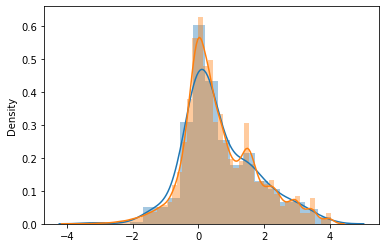

In [20]:
sns.distplot(X_rus)
sns.distplot(X_ros)

# Over-sampling: SMOTE

In [21]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import random

Synthetic Minority Oversampling Technique using synthetic data

Original dataset shape Counter({0: 9900, 1: 100})
Resample dataset shape Counter({0: 9900, 1: 9900})


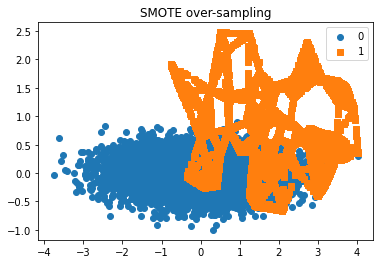

In [22]:
# import library
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))
plot_2d_space(x_smote, y_smote, 'SMOTE over-sampling')

In [23]:
##Using SMOTE to balance the data
#Define model
model=RandomForestClassifier()
#Define SMOTE
smt_resample = SMOTE(sampling_strategy='all')
#Define pipeline
pipeline=Pipeline(steps=[('r', smt_resample), ('m', model)])
#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores['test_recall_macro']))

Mean Accuracy: 0.9471
Mean Precision: 0.5649
Mean Recall: 0.8545


Comparing the SMOTE distribution to OverSample 

<AxesSubplot:ylabel='Density'>

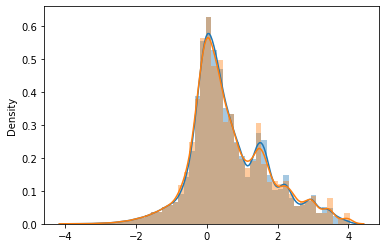

In [24]:
sns.distplot(x_smote)
sns.distplot(X_ros)

# Over-sampling followed by under-sampling

Synthetic data in the neigbourhood

original dataset shape: Counter({0: 9900, 1: 100})
SMOTE dataset shape Counter({0: 9664, 1: 9664})


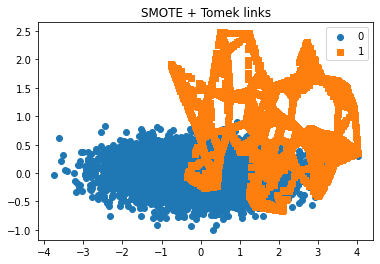

In [25]:
from imblearn.combine import SMOTETomek

smtk = SMOTETomek()
X_smtk, y_smtk = smtk.fit_resample(X, y)
print('original dataset shape:', Counter(y))
print('SMOTE dataset shape', Counter(y_smtk))

plot_2d_space(X_smtk, y_smtk, 'SMOTE + Tomek links')

In [26]:
##Using SMOTE-ENN to balance the data
#Define model
model=RandomForestClassifier()
#Define SMOTek
smtk_resample = SMOTETomek(sampling_strategy='all')
#Define pipeline
pipeline=Pipeline(steps=[('r', smtk_resample), ('m', model)])
#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores['test_recall_macro']))

Mean Accuracy: 0.9497
Mean Precision: 0.5672
Mean Recall: 0.8525


## NearMiss

NearMiss is an under-sampling technique. Instead of resampling the Minority class, using a distance, this will make the majority class equal to the minority class.

Original dataset shape: Counter({0: 9900, 1: 100})
Resample dataset shape: Counter({0: 100, 1: 100})


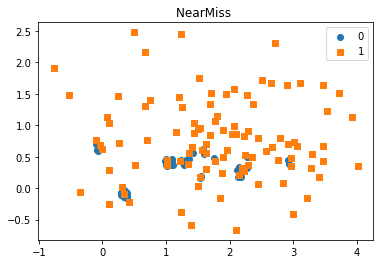

In [27]:
from imblearn.under_sampling import NearMiss

nm = NearMiss()

x_nm, y_nm = nm.fit_resample(X, y)

print('Original dataset shape:', Counter(y))
print('Resample dataset shape:', Counter(y_nm))
plot_2d_space(x_nm, y_nm, 'NearMiss ')

In [28]:
##Using SMOTE-ENN to balance the data
#Define model
model=RandomForestClassifier()
#Define SMOTE-ENN
nm_resample = NearMiss(sampling_strategy='all')
#Define pipeline
pipeline=Pipeline(steps=[('r', nm_resample), ('m', model)])
#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores['test_recall_macro']))

Mean Accuracy: 0.1966
Mean Precision: 0.5046
Mean Recall: 0.5711


# Change the performance metrics

In [29]:
# load library
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [30]:
# we can add class_weight='balanced' to add panalize mistake
svc_model = SVC(class_weight='balanced', probability=True)

svc_model.fit(X_train, y_train)

svc_predict = svc_model.predict(X_test)# check performance
print('ROCAUC score:',roc_auc_score(y_test, svc_predict))
print('Accuracy score:',accuracy_score(y_test, svc_predict))
print('F1 score:',f1_score(y_test, svc_predict))

ROCAUC score: 0.6918051756785188
Accuracy score: 0.8122270742358079
F1 score: 0.45765765765765765


We will run again the original data over Random forest Classifier

In [31]:
# load library
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

# fit the predictor and target
rfc.fit(X_train, y_train)

# predict
rfc_predict = rfc.predict(X_test)# check performance
print('ROCAUC score:',roc_auc_score(y_test, rfc_predict))
print('Accuracy score:',accuracy_score(y_test, rfc_predict))
print('F1 score:',f1_score(y_test, rfc_predict))

ROCAUC score: 0.7088260046286556
Accuracy score: 0.8920773549594511
F1 score: 0.557544757033248


The best results are provided by Mean RandomOverSampler:
Accuracy: 0.9929
Mean Precision: 0.8479
Mean Recall: 0.7621

Creating Train DataFrame with ROS Strategy

In [59]:
ros = RandomOverSampler()
columns=X_train.columns
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)
df_ros = pd.DataFrame(X_train_oversampled, columns=X_train.columns)
df_ros['host_is_superhost'] = y_train_oversampled

In [60]:
df_train.columns

Index(['host_neighbourhood', 'host_total_listings_count',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'bedrooms',
       'beds', 'bed_type', 'price', 'weekly_price', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'calendar_updated', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'host_is_superhost'],
      dtype='object')

In [61]:
df_ros.columns

Index(['host_neighbourhood', 'host_total_listings_count',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'bedrooms',
       'beds', 'bed_type', 'price', 'weekly_price', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'calendar_updated', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location', 'split',
       'host_is_superhost'],
      dtype='object')

In [62]:
df_ros

,host_neighbourhood,host_total_listings_count,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,bedrooms,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,split,host_is_superhost
0,49.0,1,0,54.0,19.0,52.340700,4.917093,1.0,0.0,1,...,0,0,96,10,9,10,10,9,0.0,0
1,49.0,2,0,11.0,8.0,52.356539,4.899771,2.0,1.0,1,...,316,0,100,10,10,10,10,10,0.0,0
2,49.0,1,0,38.0,21.0,52.352463,4.863346,1.0,0.0,1,...,355,50,95,9,9,10,10,9,0.0,1
3,32.0,1,0,38.0,21.0,52.351043,4.861912,13.0,0.0,1,...,0,14,86,9,8,10,9,9,0.0,0
4,15.0,1,0,18.0,14.0,52.362870,4.934647,1.0,0.0,2,...,0,24,96,10,10,10,10,9,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24293,46.0,1,1,56.0,4.0,52.366918,4.909642,18.0,1.0,1,...,179,350,97,10,10,10,10,10,0.0,1
24294,32.0,1,0,38.0,21.0,52.342786,4.849849,3.0,0.0,2,...,42,92,97,10,10,10,10,9,0.0,1
24295,49.0,1,0,33.0,17.0,52.351218,4.914389,1.0,0.0,0,...,63,42,99,10,10,10,10,9,0.0,1
24296,13.0,4,0,15.0,21.0,52.352552,4.849991,1.0,0.0,2,...,0,25,97,10,10,10,10,9,0.0,1


In [63]:
df_ros.shape

(24298, 33)

In [64]:
df_train.shape

(16024, 32)

In [65]:
df_train.head()

,host_neighbourhood,host_total_listings_count,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,bedrooms,...,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,host_is_superhost
0,16.0,1,1,19.0,5.0,52.380491,4.887432,1.0,0.0,2,...,0,158,16,100,10,10,10,10,10,0
1,31.0,1,0,37.0,7.0,52.367068,4.866769,1.0,1.0,1,...,34,34,12,87,9,9,9,9,9,0
2,41.0,1,0,50.0,16.0,52.391986,4.925497,13.0,0.0,4,...,0,0,10,92,9,9,9,10,9,0
3,8.0,1,1,11.0,8.0,52.350850,4.895104,1.0,0.0,1,...,0,0,13,97,10,9,10,10,10,0
4,31.0,1,0,37.0,7.0,52.369953,4.858866,15.0,0.0,1,...,0,0,14,80,9,7,8,9,9,0


In [71]:
#del df_train['split']
del df_ros['split']

In [68]:
df_train.head()

,host_neighbourhood,host_total_listings_count,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,bedrooms,...,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,host_is_superhost
0,16.0,1,1,19.0,5.0,52.380491,4.887432,1.0,0.0,2,...,0,158,16,100,10,10,10,10,10,0
1,31.0,1,0,37.0,7.0,52.367068,4.866769,1.0,1.0,1,...,34,34,12,87,9,9,9,9,9,0
2,41.0,1,0,50.0,16.0,52.391986,4.925497,13.0,0.0,4,...,0,0,10,92,9,9,9,10,9,0
3,8.0,1,1,11.0,8.0,52.350850,4.895104,1.0,0.0,1,...,0,0,13,97,10,9,10,10,10,0
4,31.0,1,0,37.0,7.0,52.369953,4.858866,15.0,0.0,1,...,0,0,14,80,9,7,8,9,9,0


In [69]:
df_ros.head()

,host_neighbourhood,host_total_listings_count,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,bedrooms,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,split,host_is_superhost
0,49.0,1,0,54.0,19.0,52.340700,4.917093,1.0,0.0,1,...,0,0,96,10,9,10,10,9,0.0,0
1,49.0,2,0,11.0,8.0,52.356539,4.899771,2.0,1.0,1,...,316,0,100,10,10,10,10,10,0.0,0
2,49.0,1,0,38.0,21.0,52.352463,4.863346,1.0,0.0,1,...,355,50,95,9,9,10,10,9,0.0,1
3,32.0,1,0,38.0,21.0,52.351043,4.861912,13.0,0.0,1,...,0,14,86,9,8,10,9,9,0.0,0
4,15.0,1,0,18.0,14.0,52.362870,4.934647,1.0,0.0,2,...,0,24,96,10,10,10,10,9,0.0,0


In [72]:
df_ros.shape

(24298, 32)

In [73]:
df_train.shape

(16024, 32)

In [74]:
df_ros.to_csv('df_ros.csv')

# Next to stage 6 - Model selection